# Applying GIRAFFE on in silico data

In this notebook, we aim to investigate the performance of GIRAFFE on two artificial datasets. These datasets are designed to be representative of the underlying biology, and show that GIRAFFE performs well under those assumptions. We will use PANDA [1], OTTER [2], and the motif as comparisons. 

## 1. Load required packages

We load GIRAFFE and other required packages. PANDA and OTTER are available on netZooPy. Feel free to check [here](https://netzoopy.readthedocs.io/en/latest/install/index.html) for more information about installing netZooPy. 

In [1]:
import giraffe
import matplotlib.pyplot as plt
import networkx as nx
from netZooPy.otter.otter import otter
from netZooPy.panda.panda import Panda 
import numpy as np
from numpy.random import default_rng
import pandas as pd
import random
import scipy
from scipy import stats

## 2. Recovering ground-truth from model satisfying our assumptions

In TODO we present GIRAFFE and its underlying assumptions. Here we create a toy dataset to show that GIRAFFE performs well under those assumptions. We need to generate the true regulation matrix R, the transcription factor activity matrix TFA, the PPI network, the gene expression, and the motif. The number of genes, transcription factors, and samples are picked to be coherent with the typical biological setting. 

In [2]:
TF = 100  # Number of transcription factors
G = 500  # Number of genes
n = 50  # Number of samples

We start with the PPI network, an undirected graph where the degree of each edge is sampled according to the distribution observed on real data. 

In [3]:
def generate_ppi(tf):
    sample_ppi = pd.read_csv('data/sample_data/PPI.csv') #  PPI from human data
    degree = nx.degree_histogram(nx.from_numpy_matrix(sample_ppi.to_numpy()))
    degree_prob = [d / np.sum(degree) for d in degree] #  Degree distribution for each node
    
    #  Sample degrees for each node according to distribution observed in real data
    D = random.choices(population = [i for i in range(len(degree_prob))], weights = degree_prob, k = tf)
    G = nx.expected_degree_graph(D) 
    PPI = nx.to_numpy_array(G) #  Create undirected PPI network
    np.fill_diagonal(PPI, 1) #  By definition, transcription factors interact with themselves
    giraffe.utils.check_symmetric(PPI) #  Sanity check
    return PPI

We assume that transcription factors form a protein complex if they form a clique in the PPI. The next piece of code return the cliques, i.e. the protein complexes, for every transcription factor. 

In [4]:
def find_cliques(ppi) :
    """
    Returns a maps from a transcription factor to the id of the cliques it belongs to
    """
    G = nx.from_numpy_array(ppi)
    cliques = {}
    idx = 0
    for i in nx.find_cliques(G):
        if len(i) > 1:
            for protein in i:
                if protein in cliques.keys():
                    cliques[protein] = cliques[protein] + [idx]
                else:
                    cliques[protein] = [idx]
            idx += 1
    # idx: number of cliques in ppi
    # map from transcription factor to its cliques (cliques of size 1 are neglected)
    return idx, cliques

At this point we are ready to generate the TFA matrix. For each protein complex we generate its activity. The row corresponding to a given transcription factor is the sum of the quantity of its protein complexes.If a transcription factor is not part of a protein complex, we assume that it regulates genes independently from the others. 

In [5]:
def generate_tfa(ppi, n):
    tf = ppi.shape[0]
    
    cliques_no, cliques = find_cliques(ppi) #  number of cliques and map tf -> cliques_id
    cliques_quantity = np.zeros((n, cliques_no)) #  quantity for each protein complex
    
    #  Generate quantity for each complex
    for i in range(cliques_no) :
        A = np.random.uniform(-1, 1, n)
        cliques_quantity[:, i] = A
    
    # The quantity for each tf is the sum of the cliques it belongs to
    TFA = np.zeros((tf, n))
    for k, v in cliques.items() :
        TFA[k, :] = np.sum(cliques_quantity[:, [v]])
    
    # If a transcription factor is not part of a complex, it can still be active
    for i in range(tf) :
        if np.sum(TFA[i, :]) == 0 :
            TFA[i, :] = np.random.uniform(-1, 1, n)
            
    return TFA #  Generated matrix

The mechanism to generate the true regulation matrix (which serves as ground-truth to estimate the performance) is similar: each protein complex (i.e. each clique in the PPI) has a sparse regulation vector describing its relationship with the target genes. Hence, for for each column in R, we sum the generated regulation vectors for each protein complex the transcription factor belongs to. If a transcription factor is not part of any complex, it can still regulate genes independently. 

In [6]:
def generate_regulation(g, tf, ppi) :
    sparsity = 0.5
    rng = default_rng()
    rvs = stats.uniform(loc = -1, scale = 2).rvs
    
    R = np.zeros((g, tf)) #  To store the ground-truth regulation matrix
    
    cliques_no, cliques = find_cliques(ppi) #  number of cliques and map tf -> cliques_id
    cliques_to_regulation = np.zeros((g, cliques_no)) #  How much each clique regulates the genes
    
    for i in range(cliques_no) :
        regulation = scipy.sparse.random(g, 1, sparsity, random_state = rng, data_rvs = rvs).A
        cliques_to_regulation[:, i] = regulation.flatten()
    
    for k, v in cliques.items() :
        R[:, k] = np.sum(cliques_to_regulation[:, [v]])
    
    #  If a transcription factor is not part of any clique, it can still regulate gene expression 
    for i in range(tf) :
        if np.sum(R[:, i]) == 0 :
            R[:, i] = scipy.sparse.random(g, 1, sparsity, random_state = rng, data_rvs = rvs).A.flatten()
            
    return R #  Generated matrix

We generate a binary motif as follows. First, we map each non-zero entry of R to one, resulting in a binary matrix. Then we we flip a certain number of entries, such that a zero (i.e. no regulation) becomes a one (i.e. regulation) and viceversa. The ratio of flipped bits is passed as the parameter shuffle to the function. 

In [7]:
def generate_motif(R, shuffle = 0.2):
    motif = R.copy()
    motif[motif != 0] = 1
    to_shuffle = int(motif.shape[0] * motif.shape[1] * shuffle)
    for i in range(to_shuffle) :
        x = np.random.randint(0, R.shape[0])
        y = np.random.randint(0, R.shape[1])
        if motif[x, y] == 1 :
            motif[x, y] = 0
        else :
            motif[x, y] = 1
    return motif

The expression matrix is generated as the product of the ground-truth matrices R and TFA. This is coherent with our underlying assumption that gene expression can be factorized as this product. 

In [8]:
def compute_expression(R, TFA) :
    return R.dot(np.abs(TFA)) 

Now we have all the required data for our simulation. We generated both the input to estimate the parameters of our model (gene expression, the PPI, and the motif), and the ground-truth to measure its performance(the regulation and transcription factor activity matrix). 

In [9]:
def simulation(n = 50, shuffling = 0.2):
    tf = 100
    g = 500

    ppi = generate_ppi(tf)
    TFA = generate_tfa(ppi, n)
    R = generate_regulation(g, tf, ppi)
    gene_expression = compute_expression(R, TFA)
    motif = generate_motif(R, shuffling)
    
    R_giraffe = giraffe.Giraffe(gene_expression, motif, ppi, lr = 0.0001).get_regulation()
    R_otter = otter(motif.T, ppi, np.corrcoef(gene_expression), Iter = 200).T
    R_panda = giraffe.compute_panda_locally(gene_expression, motif, ppi)
    print(R_panda)
    return giraffe.plot_auroc(R, [R_giraffe, R_otter, R_panda, motif], ["Our method", "OTTER", "PANDA", "Motif"], title = "AUROC, reliability of the motif = " + str(1 - shuffling))

Loading motif data ...
  Elapsed time: 0.01 sec.
Loading PPI data ...
Number of PPIs: 216
  Elapsed time: 0.00 sec.
Calculating coexpression network ...
  Elapsed time: 0.00 sec.
Creating motif network ...
  Elapsed time: 0.02 sec.
Creating PPI network ...
  Elapsed time: 0.00 sec.
union tmp/motif.txt              0           1           2           3           4           5   \
0   -350.394519 -349.957868 -350.751342 -351.072080 -350.353399 -351.471160   
1   -351.795564 -352.648044 -351.173256 -350.960038 -353.674487 -349.717063   
2   -352.721492 -351.011327 -353.336271 -351.696689 -351.183241 -350.512895   
3   -351.555989 -352.605933 -355.024862 -353.265758 -351.731797 -353.682335   
4   -355.916635 -352.048480 -354.629882 -355.222817 -353.856246 -355.183998   
..          ...         ...         ...         ...         ...         ...   
495 -351.607135 -352.491223 -352.851979 -351.278326 -352.245964 -352.218896   
496 -357.847361 -356.834760 -356.435225 -355.642641 -357.614641 -

step: 129, hamming: 79333.4841239254
step: 130, hamming: 64953.5223542701
step: 131, hamming: 53179.9399142304
step: 132, hamming: 43540.371860285035
step: 133, hamming: 35648.0474241413
step: 134, hamming: 29186.284581273652
step: 135, hamming: 23895.792616866103
step: 136, hamming: 19564.2731848283
step: 137, hamming: 16017.905133566765
step: 138, hamming: 13114.371871983643
step: 139, hamming: 10737.151853030686
step: 140, hamming: 8790.843686982422
step: 141, hamming: 7197.338221440445
step: 142, hamming: 5892.684391291199
step: 143, hamming: 4824.523044730835
step: 144, hamming: 3949.9858339003526
step: 145, hamming: 3233.9749721838684
step: 146, hamming: 2647.754670588806
step: 147, hamming: 2167.798012019493
step: 148, hamming: 1774.8426916145859
step: 149, hamming: 1453.1180973141327
step: 150, hamming: 1189.7122944841385
step: 151, hamming: 974.0538604470291
step: 152, hamming: 797.4877193127518
step: 153, hamming: 652.9276149229355
step: 154, hamming: 534.5718363895263
step: 

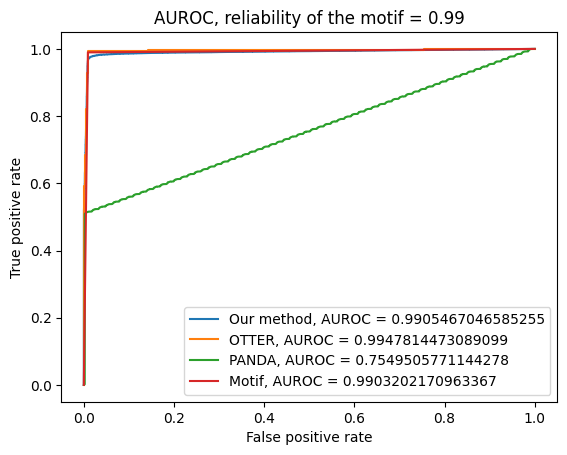

Loading motif data ...
  Elapsed time: 0.01 sec.
Loading PPI data ...
Number of PPIs: 200
  Elapsed time: 0.00 sec.
Calculating coexpression network ...
  Elapsed time: 0.00 sec.
Creating motif network ...
  Elapsed time: 0.02 sec.
Creating PPI network ...
  Elapsed time: 0.00 sec.
union tmp/motif.txt              0           1           2           3           4           5   \
0    560.958436  561.075989  563.364913  560.785126  562.444516  563.621115   
1    561.664072  561.172902  561.587329  560.362744  562.046993  562.526958   
2    560.628405  563.093516  561.697140  561.398919  562.895269  562.088746   
3    561.043704  558.928074  558.480273  559.078843  559.439278  560.516807   
4    561.797029  560.200133  562.640229  560.883707  560.386767  559.189264   
..          ...         ...         ...         ...         ...         ...   
495  560.422353  560.905822  562.378178  561.847511  563.806040  562.023800   
496  564.706169  562.796233  562.478331  562.805490  562.819380  

step: 124, hamming: 615854.0946058489
step: 125, hamming: 508169.1223616793
step: 126, hamming: 418648.51439372386
step: 127, hamming: 344469.5998635554
step: 128, hamming: 283156.3152134388
step: 129, hamming: 232575.18788168943
step: 130, hamming: 190911.0000195286
step: 131, hamming: 156632.79839410755
step: 132, hamming: 128457.87682593698
step: 133, hamming: 105317.12185888516
step: 134, hamming: 86322.52595338145
step: 135, hamming: 70738.81332103252
step: 136, hamming: 57958.48535690701
step: 137, hamming: 47480.594644628974
step: 138, hamming: 38892.55077815648
step: 139, hamming: 31854.945841958943
step: 140, hamming: 26088.858455150657
step: 141, hamming: 21365.20197490457
step: 142, hamming: 17495.949383384337
step: 143, hamming: 14326.849642945372
step: 144, hamming: 11731.398847038408
step: 145, hamming: 9605.890536415658
step: 146, hamming: 7865.3182388179885
step: 147, hamming: 6440.020869413749
step: 148, hamming: 5272.932314860105
step: 149, hamming: 4317.299615367554


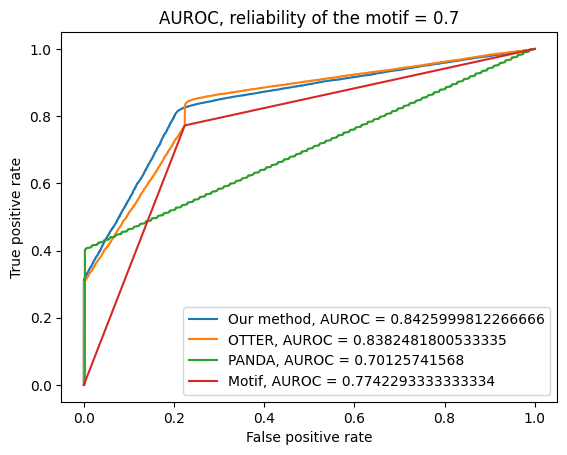

Loading motif data ...
  Elapsed time: 0.01 sec.
Loading PPI data ...
Number of PPIs: 200
  Elapsed time: 0.00 sec.
Calculating coexpression network ...
  Elapsed time: 0.00 sec.
Creating motif network ...
  Elapsed time: 0.03 sec.
Creating PPI network ...
  Elapsed time: 0.00 sec.
union tmp/motif.txt              0           1           2           3           4           5   \
0    557.312090  558.910664  557.083205  558.823318  560.418153  559.148766   
1    560.657272  558.525325  561.538319  557.623569  558.688224  560.645837   
2    562.602334  563.629523  564.122658  560.290911  562.662380  564.135010   
3    560.324139  562.047858  559.790195  560.482666  561.629562  559.992494   
4    555.528454  557.152582  558.771820  557.299907  557.232529  560.094321   
..          ...         ...         ...         ...         ...         ...   
495  559.318308  560.400302  559.926701  557.381670  558.115822  557.023072   
496  560.007735  558.355004  559.764007  559.324141  560.486053  

step: 120, hamming: 1908758.3951488857
step: 121, hamming: 1622436.989160728
step: 122, hamming: 1367364.5979302276
step: 123, hamming: 1144970.285524263
step: 124, hamming: 954044.7714705792
step: 125, hamming: 791972.9509409568
step: 126, hamming: 655532.5497204371
step: 127, hamming: 541381.171750145
step: 128, hamming: 446324.44297767244
step: 129, hamming: 367451.56805415865
step: 130, hamming: 302187.2905791664
step: 131, hamming: 248299.64512540426
step: 132, hamming: 203880.41102867736
step: 133, hamming: 167314.65548589441
step: 134, hamming: 137245.66742413378
step: 135, hamming: 112540.11595857616
step: 136, hamming: 92254.95205036807
step: 137, hamming: 75608.37171182317
step: 138, hamming: 61953.72325282034
step: 139, hamming: 50757.17286554779
step: 140, hamming: 41578.887122640976
step: 141, hamming: 34056.77263993527
step: 142, hamming: 27893.20794644811
step: 143, hamming: 22843.579111708408
step: 144, hamming: 18707.065785352534
step: 145, hamming: 15318.914981527894


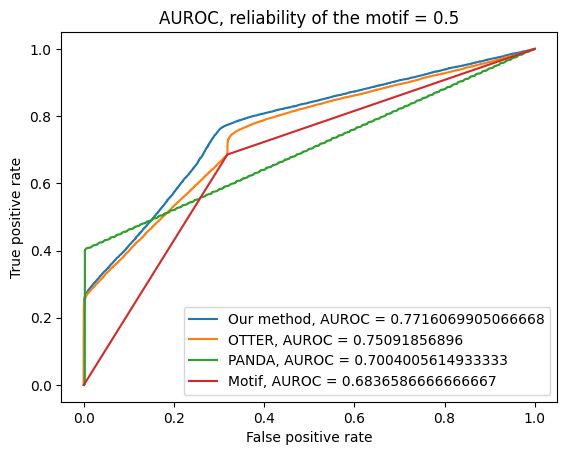

Loading motif data ...
  Elapsed time: 0.00 sec.
Loading PPI data ...
Number of PPIs: 200
  Elapsed time: 0.00 sec.
Calculating coexpression network ...
  Elapsed time: 0.00 sec.
Creating motif network ...
  Elapsed time: 0.02 sec.
Creating PPI network ...
  Elapsed time: 0.00 sec.
union tmp/motif.txt              0           1           2           3           4           5   \
0    561.270379  560.021851  558.012833  558.754294  557.607432  558.777115   
1    559.816652  560.275062  560.435776  557.755635  558.932485  558.843228   
2    558.020761  557.774754  558.990401  558.273440  559.782966  560.138448   
3    557.876968  561.224733  560.691879  559.303136  559.344243  563.260191   
4    559.668407  558.877289  559.320101  560.669528  561.480956  560.722067   
..          ...         ...         ...         ...         ...         ...   
495  556.419922  557.999308  557.674455  558.385879  556.966215  557.515952   
496  562.632419  560.839975  562.698344  560.987183  561.316236  

step: 128, hamming: 171003.94081835455
step: 129, hamming: 140315.36559958942
step: 130, hamming: 115086.0057597799
step: 131, hamming: 94361.08619245065
step: 132, hamming: 77347.17893834108
step: 133, hamming: 63386.9250605961
step: 134, hamming: 51936.988559871126
step: 135, hamming: 42549.099790795466
step: 136, hamming: 34853.98554971819
step: 137, hamming: 28547.797111068183
step: 138, hamming: 23380.761691780448
step: 139, hamming: 19147.72162200997
step: 140, hamming: 15680.250616049992
step: 141, hamming: 12840.16355253443
step: 142, hamming: 10514.129881026076
step: 143, hamming: 8609.225535738651
step: 144, hamming: 7049.283887606455
step: 145, hamming: 5771.889905402514
step: 146, hamming: 4725.901891303881
step: 147, hamming: 3869.4225474606637
step: 148, hamming: 3168.1322740053824
step: 149, hamming: 2593.923726206584
step: 150, hamming: 2123.7742132783483
step: 151, hamming: 1738.83061966442
step: 152, hamming: 1423.6537891749435
step: 153, hamming: 1165.601786991683
st

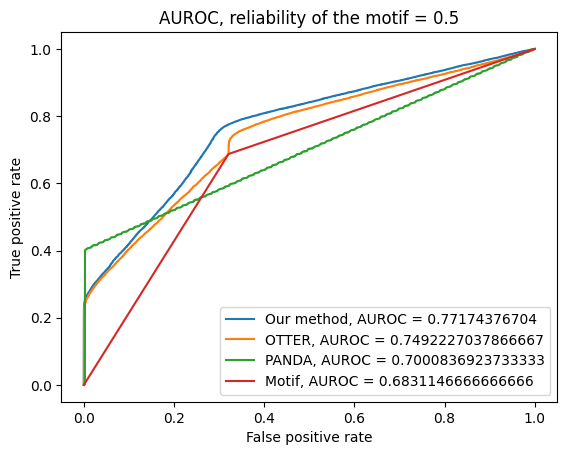

Loading motif data ...
  Elapsed time: 0.00 sec.
Loading PPI data ...
Number of PPIs: 200
  Elapsed time: 0.00 sec.
Calculating coexpression network ...
  Elapsed time: 0.00 sec.
Creating motif network ...
  Elapsed time: 0.03 sec.
Creating PPI network ...
  Elapsed time: 0.00 sec.
union tmp/motif.txt              0           1           2           3           4           5   \
0    561.018832  561.642815  561.476965  561.547278  563.645780  561.564338   
1    558.656834  557.778310  558.234082  557.489573  557.408713  558.761346   
2    558.633076  562.012707  561.054689  561.557839  560.311911  562.308658   
3    561.394210  558.831049  561.287247  560.026304  559.056682  559.651654   
4    561.442800  562.608130  561.232477  562.779484  563.186393  562.707478   
..          ...         ...         ...         ...         ...         ...   
495  561.132972  563.257309  562.275076  560.924978  560.194443  560.829969   
496  560.864225  560.437780  562.028499  559.914804  561.239580  

step: 130, hamming: 42082.47138090098
step: 131, hamming: 34467.48452550777
step: 132, hamming: 28228.390015055116
step: 133, hamming: 23117.2850783841
step: 134, hamming: 18930.692833200945
step: 135, hamming: 15501.692464379781
step: 136, hamming: 12693.396453454581
step: 137, hamming: 10393.584184663918
step: 138, hamming: 8510.277589187239
step: 139, hamming: 6968.10497655477
step: 140, hamming: 5705.31553905464
step: 141, hamming: 4671.3219800432125
step: 142, hamming: 3824.6879665338924
step: 143, hamming: 3131.476000507539
step: 144, hamming: 2563.8912528541878
step: 145, hamming: 2099.1722739018414
step: 146, hamming: 1718.679608551272
step: 147, hamming: 1407.150026568162
step: 148, hamming: 1152.0859197900224
step: 149, hamming: 943.25367694807
step: 150, hamming: 772.2741177785466
step: 151, hamming: 632.2865230927644
step: 152, hamming: 517.6735415739226
step: 153, hamming: 423.8358648705585
step: 154, hamming: 347.0077573772192
step: 155, hamming: 284.1060637531433
step: 1

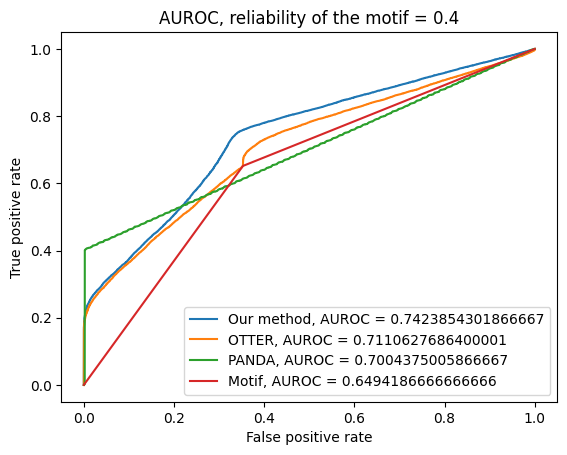

Loading motif data ...
  Elapsed time: 0.00 sec.
Loading PPI data ...
Number of PPIs: 200
  Elapsed time: 0.00 sec.
Calculating coexpression network ...
  Elapsed time: 0.00 sec.
Creating motif network ...
  Elapsed time: 0.02 sec.
Creating PPI network ...
  Elapsed time: 0.00 sec.
union tmp/motif.txt              0           1           2           3           4           5   \
0    561.309901  561.078871  560.608662  562.241947  561.345107  559.659217   
1    562.787646  562.042685  563.030938  561.728558  562.389127  561.647610   
2    559.625094  561.007280  558.221826  560.204538  559.700301  559.288181   
3    558.816383  560.331287  560.207859  558.753882  562.148287  561.770894   
4    556.944746  557.622633  554.973458  557.029569  559.088032  556.332133   
..          ...         ...         ...         ...         ...         ...   
495  561.520597  560.563154  561.440901  560.464813  561.461784  562.555059   
496  563.244638  563.240538  563.175677  562.961449  563.078780  

step: 130, hamming: 63885.542856262146
step: 131, hamming: 52369.69965411945
step: 132, hamming: 42919.68098382614
step: 133, hamming: 35168.2488725659
step: 134, hamming: 28812.32638205122
step: 135, hamming: 23602.15690783915
step: 136, hamming: 19332.194367231285
step: 137, hamming: 15833.421427751848
step: 138, hamming: 12966.994777160771
step: 139, hamming: 10618.917087304259
step: 140, hamming: 8695.647574705547
step: 141, hamming: 7120.460325589016
step: 142, hamming: 5830.442735627543
step: 143, hamming: 4774.024728015835
step: 144, hamming: 3908.9440097248657
step: 145, hamming: 3200.5721567464666
step: 146, hamming: 2620.5362218189694
step: 147, hamming: 2145.598486893399
step: 148, hamming: 1756.7222754125976
step: 149, hamming: 1438.318053899584
step: 150, hamming: 1177.6180102675885
step: 151, hamming: 964.166275127115
step: 152, hamming: 789.4015736519189
step: 153, hamming: 646.31310995497
step: 154, hamming: 529.159946573507
step: 155, hamming: 433.2417009963501
step: 1

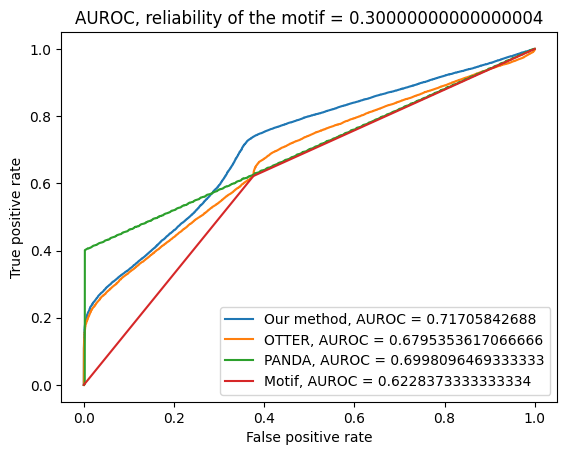

Loading motif data ...
  Elapsed time: 0.01 sec.
Loading PPI data ...
Number of PPIs: 200
  Elapsed time: 0.00 sec.
Calculating coexpression network ...
  Elapsed time: 0.00 sec.
Creating motif network ...
  Elapsed time: 0.02 sec.
Creating PPI network ...
  Elapsed time: 0.00 sec.
union tmp/motif.txt              0           1           2           3           4           5   \
0    557.793964  557.850035  556.332836  560.558707  557.679443  557.228454   
1    559.527791  558.308998  558.416045  559.707765  558.979283  558.875194   
2    559.825459  557.908043  557.464170  558.600055  559.119003  556.953331   
3    560.427734  560.634337  560.866694  561.130296  561.227548  560.837460   
4    559.623354  560.221905  558.191765  560.572942  561.611666  560.621290   
..          ...         ...         ...         ...         ...         ...   
495  559.584194  558.879212  558.115583  559.440289  559.442131  557.683274   
496  560.939249  562.373802  560.645438  559.359977  560.227671  

step: 130, hamming: 55002.03090897592
step: 131, hamming: 45070.870159787766
step: 132, hamming: 36926.849237112576
step: 133, hamming: 30250.386019428493
step: 134, hamming: 24778.37059075036
step: 135, hamming: 20294.413863771548
step: 136, hamming: 16620.70093876641
step: 137, hamming: 13611.217832530114
step: 138, hamming: 11146.13017148634
step: 139, hamming: 9127.138756251175
step: 140, hamming: 7473.632527673181
step: 141, hamming: 6119.527332296528
step: 142, hamming: 5010.662556790627
step: 143, hamming: 4102.656888626343
step: 144, hamming: 3359.1499881327513
step: 145, hamming: 2750.3558407935884
step: 146, hamming: 2251.8765963067226
step: 147, hamming: 1843.729530298576
step: 148, hamming: 1509.5496366891682
step: 149, hamming: 1235.9349474443543
step: 150, hamming: 1011.910711673432
step: 151, hamming: 828.4905073324641
step: 152, hamming: 678.3156971940492
step: 153, hamming: 555.3610128524306
step: 154, hamming: 454.6930136916405
step: 155, hamming: 372.2721901190939
st

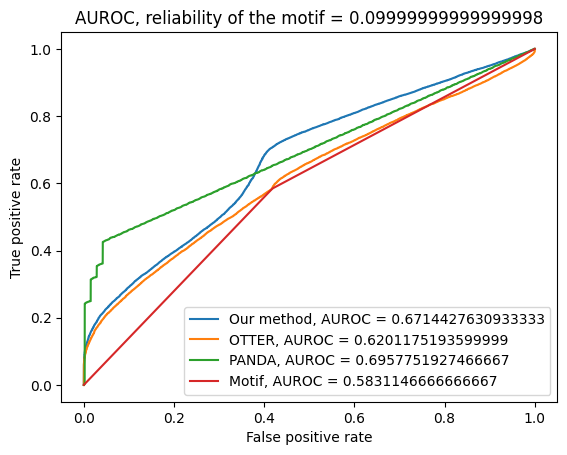

In [10]:
shuffling = [0.01, 0.3, 0.5, 0.5, 0.6, 0.7, 0.9]

scores = []
for shuffle in shuffling :
    scores.append(simulation(shuffling = shuffle))
    
giraffe.utils.star_plot(list(map(list, zip(*scores))), [str(round(1 - shuffle, 2)) for shuffle in shuffling], ["Our method", "OTTER", "PANDA", "Motif"])

We observe how GIRAFFE is the best method across multiple noise setting. Moreover it is the most robust one: PANDA outperforms it in the case where the motif is non-reliable, but it performs significantly worse in the case the motif is reliable. OTTER has similar performance for a reliable motif, but it gets worse as the motif gradually becomes more corrupted. 

## 3. Recovering ground-truth from projections

We create a new toy dataset. The dimensionality are picked to be coherent with the typical biological setting. 

In [11]:
TF = 100  # Number of transcription factors
G = 500  # Number of genes
n = 50  # Number of samples

Similarly as before, we need to simulate the ground-truth regulation matrix R. We generate a sparse matrix, where non-zero entries are uniformly sampled in (0, 1). 

In [12]:
def generate_regulation(g, tf) :
    sparsity = 0.2
    rng = default_rng()
    rvs = stats.uniform(loc = 0, scale = 1).rvs
    R = scipy.sparse.random(g, tf, sparsity, random_state = rng, data_rvs = rvs).A
    return R

The motif is computed from the true regulation matrix by corrupting it with random uniform noise. 

In [13]:
def generate_motif(r):
    return r + np.random.uniform(-1, 1, (r.shape[0], r.shape[1]))

We decide that two proteins interact if they co-regulate "many" genes. To pick a proper threshold value, we plot the distribution of the number of co-regulated genes. 

(0.0, 470.0)

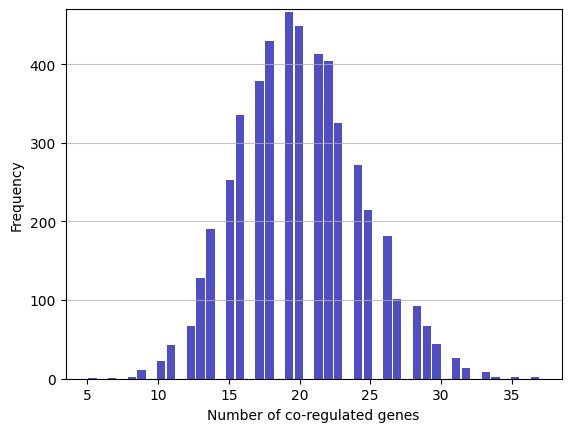

In [14]:
R = generate_regulation(G, TF)

cooperation = []
R[R != 0] = 1
for i in range(TF):
    for j in range(i + 1, TF):
        cooperation.append(R[:, i].dot(R[:, j]))

"The following lines or code are taken from https://realpython.com/python-histograms/ [Accessed on Jan. 13th 2023]"
s, bins, patches = plt.hist(x = cooperation, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha = 0.75)
plt.xlabel('Number of co-regulated genes')
plt.ylabel('Frequency')
maxfreq = s.max()
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

We want a sparse PPI, so we heuristically pick 25 as threshold value (larger than the mean, but small enough to recover enough information). We now construct the PPI network. 

In [15]:
def generate_ppi(R):
    ppi = np.zeros((R.shape[1], R.shape[1]))
    R[R != 0] = 1
    for i in range(R.shape[1]):
        for j in range(R.shape[1]):
            if i == j :
                ppi[i, j] = 1 # By definition
            else :
                if R[:, i].dot(R[:, j]) >= 25:
                    ppi[i, j] = 1
    return ppi

Gene expressioned is sampled from a multi-normal distribution with mean zero and the same covariance as the regulation matrix. 

In [16]:
def generate_expression(C) :
    return np.random.multivariate_normal([0 for i in range(G)], C.T, n).T

Now we have generators for all required data: a ground-truth regulation matrix, a corrupter motif, and a PPI netork. We are ready to put the pieces together in our simulation. 

In [17]:
def simulation() :
    R = generate_regulation(G, TF)
    ppi = generate_ppi(R)
    motif = generate_motif(R)
    expression = generate_expression(R.dot(R.T))

    otter_regulation = otter(motif.T, ppi, np.corrcoef(motif))
    giraffe_oracle_regulation = giraffe.Giraffe(expression, motif, ppi, lam = [0.000001, 5, 50, 1, 1]).get_regulation()
    giraffe_agnostic_regulation = giraffe.Giraffe(expression, motif, ppi).get_regulation()
    motif[motif >= np.quantile(motif, .6)] = 1 # PANDA requires a binary motif
    motif[motif != 1] = 0
    panda_regulation = giraffe.utils.compute_panda_locally(expression, motif, ppi)
    giraffe.utils.plot_auroc(
        R, 
        [otter_regulation.T, giraffe_oracle_regulation, giraffe_agnostic_regulation,panda_regulation, motif], 
        ["OTTER", "GIRAFFE (custom weights)", "GIRAFFE (learned weights)", "PANDA", "Motif"]
    )

Loading motif data ...
  Elapsed time: 0.00 sec.
Loading PPI data ...
Number of PPIs: 1578
  Elapsed time: 0.00 sec.
Calculating coexpression network ...
  Elapsed time: 0.00 sec.
Creating motif network ...
  Elapsed time: 0.02 sec.
Creating PPI network ...
  Elapsed time: 0.00 sec.
union tmp/motif.txt            0         1          2          3         4         5         6   \
0   -4.566326 -1.897048  -8.117904   4.369149  6.542057 -5.010917 -2.849166   
1   -2.880778  3.861424   0.943518  -3.942841  2.467746  3.258672 -1.958876   
2   -8.739005 -2.829964  13.503585  -6.044239  0.666472 -1.814903 -2.846669   
3   -6.511966 -4.475434  -4.781986   4.316119  2.013219 -3.398245 -4.058056   
4   -6.691474 -7.524205  -2.823113  -3.388130  4.157867 -3.550219  2.633184   
..        ...       ...        ...        ...       ...       ...       ...   
495 -5.619021 -4.161649  -1.441657   6.373585  2.921796 -9.088015 -2.419657   
496 -4.453118 -3.256006   3.764904 -11.587350 -1.487478  1.38793

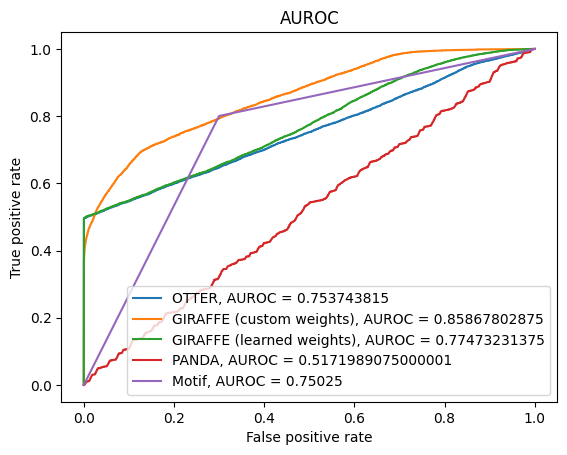

In [18]:
simulation()

We observe that GIRAFFE performs better than the other baselines. Note how GIRAFFE optionally accepts custom weights: this can be tuned (using proper statistical practices) and guide the optimization algorithm to focus on the reconstruction loss, the coherence with the PPI, or the coherence with the co-expression network. If no custom weights are provided, GIRAFFE assigns weights internally using a multi-task learning algorithm [3]. 

# Prova

In [2]:
def generate_ppi(tf):
    sample_ppi = pd.read_csv('data/sample_data/PPI.csv') #  PPI from human data
    degree = nx.degree_histogram(nx.from_numpy_matrix(sample_ppi.to_numpy()))
    degree_prob = [d / np.sum(degree) for d in degree] #  Degree distribution for each node
    #  Sample degrees for each node according to distribution observed in real data
    D = random.choices(population = [i for i in range(len(degree_prob))], weights = degree_prob, k = tf)
    G = nx.expected_degree_graph(D) 
    PPI = nx.to_numpy_array(G) #  Create undirected PPI network
    np.fill_diagonal(PPI, 1) #  By definition, transcription factors interact with themselves
    giraffe.utils.check_symmetric(PPI) #  Sanity check
    return PPI

def find_cliques(ppi) :
    """
    Returns a maps from a transcription factor to the id of the cliques it belongs to
    """
    G = nx.from_numpy_array(ppi)
    cliques = {}
    idx = 0
    for i in nx.find_cliques(G):
        if len(i) > 1:
            for protein in i:
                if protein in cliques.keys():
                    cliques[protein] = cliques[protein] + [idx]
                else:
                    cliques[protein] = [idx]
            idx += 1
    # idx: number of cliques in ppi
    # map from transcription factor to its cliques (cliques of size 1 are neglected)
    return idx, cliques

def generate_tfa(ppi, n, confounder):
    tf = ppi.shape[0]
    
    cliques_no, cliques = find_cliques(ppi) #  number of cliques and map tf -> cliques_id
    cliques_quantity = np.zeros((n, cliques_no)) #  quantity for each protein complex
    
    #  Generate quantity for each complex
    for i in range(cliques_no) :
        A = np.random.uniform(-1, 1, n)
        cliques_quantity[:, i] = A
    
    # The quantity for each tf is the sum of the cliques it belongs to
    TFA = np.zeros((tf, n))
    for k, v in cliques.items() :
        TFA[k, :] = np.sum(cliques_quantity[:, [v]])
    
    # If a transcription factor is not part of a complex, it can still be active
    for i in range(tf) :
        if np.sum(TFA[i, :]) == 0 :
            TFA[i, :] = np.random.uniform(-1, 1, n)
            
    return TFA + np.array([confounder for i in range(TFA.shape[0])])#  Generated matrix

def generate_regulation(g, tf, ppi) :
    sparsity = .9
    rng = default_rng()
    rvs = stats.uniform(loc = -1, scale = 2).rvs
    
    R = np.zeros((g, tf)) #  To store the ground-truth regulation matrix
    
    cliques_no, cliques = find_cliques(ppi) #  number of cliques and map tf -> cliques_id
    cliques_to_regulation = np.zeros((g, cliques_no)) #  How much each clique regulates the genes
    
    for i in range(cliques_no) :
        regulation = scipy.sparse.random(g, 1, sparsity, random_state = rng, data_rvs = rvs).A
        cliques_to_regulation[:, i] = regulation.flatten()
    
    for k, v in cliques.items() :
        R[:, k] = np.sum(cliques_to_regulation[:, [v]])
    
    #  If a transcription factor is not part of any clique, it can still regulate gene expression 
    for i in range(tf) :
        if np.sum(R[:, i]) == 0 :
            R[:, i] = scipy.sparse.random(g, 1, sparsity, random_state = rng, data_rvs = rvs).A.flatten()
            
    return R #  Generated matrix

def generate_motif(R, shuffle = 0.2):
    motif = R.copy()
    motif[motif != 0] = 1
    to_shuffle = int(motif.shape[0] * motif.shape[1] * shuffle)
    for i in range(to_shuffle) :
        x = np.random.randint(0, R.shape[0])
        y = np.random.randint(0, R.shape[1])
        if motif[x, y] == 1 :
            motif[x, y] = 0
        else :
            motif[x, y] = 1
    return motif

def compute_expression(R, TFA, confounder) :
    return R.dot(np.abs(TFA)) + np.array([confounder for i in range(R.shape[0])])

In [5]:
def simulation(n = 50, shuffling = 0.2, control = False):

    tf = 100
    g = 500

    ppi = generate_ppi(tf)
    confounder = np.random.uniform(200, 300, n)
    TFA = generate_tfa(ppi, n, confounder)
    R = generate_regulation(g, tf, ppi)
    gene_expression = compute_expression(R, TFA, confounder)
    motif = generate_motif(R, shuffling)
    
    R_giraffe = giraffe.Giraffe(gene_expression, motif, ppi, lr = 0.0001).get_regulation()
    R_adj = giraffe.Giraffe(gene_expression, motif, ppi, lr = 0.0001, adjusting = confounder).get_regulation()
    R_otter = otter(motif.T, ppi, np.corrcoef(gene_expression), Iter = 200).T
    R_panda = giraffe.compute_panda_locally(gene_expression, motif, ppi)
    
    
    return giraffe.plot_auroc(R, [R_giraffe, R_adj, R_otter, R_panda, motif], ["GIRAFFE", "GIRAFFE adjusted", "OTTER", "PANDA", "Motif"], title = "AUROC, reliability of the motif = " + str(1 - shuffling))

Loading motif data ...
  Elapsed time: 0.01 sec.
Loading PPI data ...
Number of PPIs: 200
  Elapsed time: 0.00 sec.
Calculating coexpression network ...
  Elapsed time: 0.00 sec.
Creating motif network ...
  Elapsed time: 0.05 sec.
Creating PPI network ...
  Elapsed time: 0.00 sec.
union tmp/motif.txt                 0              1              2              3   \
0    134908.997613  139452.762716  161154.038171  131857.703582   
1    134252.842809  138768.999316  160367.980718  131214.927843   
2    132056.750183  136506.263220  157756.493122  129071.584188   
3    132359.517072  136817.122682  158117.829630  129364.275457   
4    133248.078550  137738.202796  159182.256335  130232.329949   
..             ...            ...            ...            ...   
495  133749.353416  138256.344714  159768.954741  130721.559858   
496  135934.961582  140513.808458  162374.885361  132856.594229   
497  134380.920425  138903.603277  160524.522300  131336.842563   
498  131608.415256  136046.

step: 104, hamming: 47027343.072712645
step: 105, hamming: 46984364.17557086
step: 106, hamming: 47460949.44399296
step: 107, hamming: 48543701.62901487
step: 108, hamming: 50339236.91735551
step: 109, hamming: 52977308.80299931
step: 110, hamming: 56616566.05207284
step: 111, hamming: 61448221.967403434
step: 112, hamming: 67703642.21373555
step: 113, hamming: 75658674.1881443
step: 114, hamming: 85639314.27018145
step: 115, hamming: 98024196.74844015
step: 116, hamming: 113250733.2979799
step: 117, hamming: 131802144.59574
step: 118, hamming: 154187815.65529358
step: 119, hamming: 180909648.58909467
step: 120, hamming: 212372087.80269367
step: 121, hamming: 248758940.11808115
step: 122, hamming: 289810162.22750664
step: 123, hamming: 334562503.86390424
step: 124, hamming: 381008514.0128268
step: 125, hamming: 425869620.50679374
step: 126, hamming: 464662064.92573035
step: 127, hamming: 492393584.946933
step: 128, hamming: 504831109.3130213
step: 129, hamming: 499936271.04504365
step:

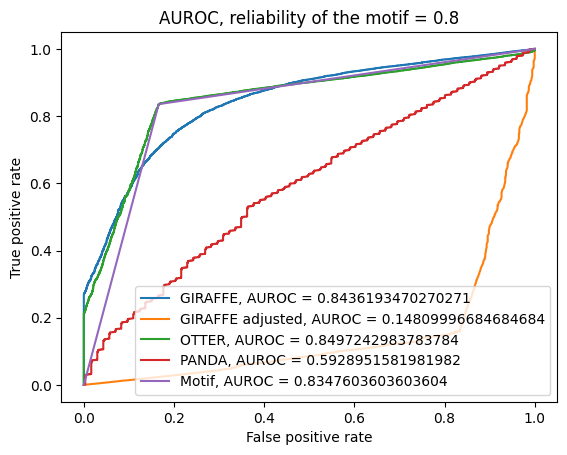

[0.8436193470270271,
 0.14809996684684684,
 0.8497242983783784,
 0.5928951581981982,
 0.8347603603603604]

In [6]:
simulation()

## References

[1] Glass K, Huttenhower C, Quackenbush J, Yuan GC. "Passing Messages Between Biological Networks to Refine Predicted Interactions", PLoS One, 2013 May 31;8(5):e64832

[2] Weighill, Deborah, et al. "Gene regulatory network inference as relaxed graph matching." Proceedings of the... AAAI Conference on Artificial Intelligence. AAAI Conference on Artificial Intelligence. Vol. 35. No. 11. NIH Public Access, 2021.

[3] Lee J.H, Kim C. S. Multi-loss rebalancing algorithm for monocular depth estimation. In European Conference on Computer Vision, pages 785–801. Springer, 2020.